# Discrete-time Switched Invariant Set


## Introduction

In this notebook, we compute the maximal (resp. minimal) invariant set contained in the square with vertices $(\pm 1, \pm 1)$ for the system
$$
\begin{aligned}
x_{k+1} & = -y_k\\
y_{k+1} & =  x_k.
\end{aligned}
$$

The system is $x_{k+1} = Ax_k$ where
$$
A = \begin{bmatrix}
0 & -1\\
1 & 0
\end{bmatrix}.
$$
A set $S$ is controlled invariant if
$$AS \subseteq S.$$

We need to pick an LP and an SDP solver, see [here](https://jump.dev/JuMP.jl/stable/installation/#Supported-solvers) for a list of available ones. Run one of the following two cells to choose choose the solver.

In [1]:
using SetProg
import Clp
lp_solver = optimizer_with_attributes(Clp.Optimizer, MOI.Silent() => true)
import CSDP
sdp_solver = optimizer_with_attributes(CSDP.Optimizer, MOI.Silent() => true)
using Polyhedra
lib = DefaultLibrary{Float64}(lp_solver)
h = HalfSpace([1, 0], 1.0) ∩ HalfSpace([-1, 0], 1) ∩ HalfSpace([0, 1], 1) ∩ HalfSpace([0, -1], 1)
□ = polyhedron(h, lib)
◇ = polar(□)
A1 = [-1 -1
      -4  0] / 4
A2 = [ 3  3
      -2  1] / 4
A = [0.0 -1.0
     1.0  0.0]

function maximal_invariant(template, heuristic::Function)
    solver = if template isa Polytope
        lp_solver
    else
        sdp_solver
    end
    model = Model(solver)
    @variable(model, S, template)
    @constraint(model, S ⊆ □)
    @constraint(model, A1 * S ⊆ S)
    @constraint(model, A2 * S ⊆ S)
    @objective(model, Max, heuristic(volume(S)))
    optimize!(model)
    @show solve_time(model)
    @show termination_status(model)
    @show objective_value(model)
    return value(S)
end
function minimal_invariant(template, heuristic::Function)
    solver = if template isa Polytope
        lp_solver
    else
        sdp_solver
    end
    model = Model(solver)
    @variable(model, S, template)
    @constraint(model, □ ⊆ S)
    @constraint(model, A1 * S ⊆ S)
    @constraint(model, A2 * S ⊆ S)
    @objective(model, Min, heuristic(volume(S)))
    optimize!(model)
    @show solve_time(model)
    @show termination_status(model)
    @show objective_value(model)
    @show JuMP.objective_sense(model)
    return value(S)
end

using Plots
function hexcolor(rgb::UInt32)
    r = ((0xff0000 & rgb) >> 16) / 255
    g = ((0x00ff00 & rgb) >>  8) / 255
    b = ((0x0000ff & rgb)      ) / 255
    Plots.RGBA(r, g, b)
end # Values taken from http://www.toutes-les-couleurs.com/code-couleur-rvb.php
lichen = hexcolor(0x85c17e)
canard = hexcolor(0x048b9a)
aurore = hexcolor(0xffcb60)
frambo = hexcolor(0xc72c48)

function primal_plot(min_sol, max_sol; npoints=256, args...)
    plot(ratio=:equal, tickfont=Plots.font(12); args...)
    plot!(min_sol, color=canard, npoints=npoints)
    plot!(□, color=lichen)
    plot!(max_sol, color=aurore, npoints=npoints)
end
function polar_plot(min_sol, max_sol; npoints=256, args...)
    plot(ratio=:equal, tickfont=Plots.font(12); args...)
    plot!(polar(max_sol), color=aurore, npoints=npoints)
    plot!(◇, color=lichen)
    plot!(polar(min_sol), color=canard, npoints=npoints)
end

polar_plot (generic function with 1 method)

## Polyhedral template

### Fixed point approach

This section shows fixed point approach for computing a polyhedral maximal invariant set.
We implement the fixed point iteration of the standard viability kernel algorithm with the following function.
A more sophisticated approach specialized for discrete-time linear switched systems
is available in [SwitchOnSafety](https://github.com/blegat/SwitchOnSafety.jl).

In [2]:
function backward_fixed_point_iteration(set::Polyhedron)
    new_set = set ∩ (A1 \ set) ∩ (A2 \ set)
    removehredundancy!(new_set)
    return new_set
end

backward_fixed_point_iteration (generic function with 1 method)

We start with $[-1, 1]^2$ and obtain the maximal invariant set after one iteration.

In [3]:
max_polytope_1 = backward_fixed_point_iteration(□)

Polyhedron DefaultPolyhedron{Float64, Polyhedra.Intersection{Float64, Vector{Float64}, Int64}, Polyhedra.Hull{Float64, Vector{Float64}, Int64}}:
6-element iterator of HalfSpace{Float64, Vector{Float64}}:
 HalfSpace([0.0, 1.0], 1.0)
 HalfSpace([0.0, -1.0], 1.0)
 HalfSpace([-1.0, 0.0], 1.0)
 HalfSpace([1.0, 0.0], 1.0)
 HalfSpace([0.75, 0.75], 1.0)
 HalfSpace([-0.75, -0.75], 1.0)

We can see that it has already converged.

In [4]:
backward_fixed_point_iteration(max_polytope_1)

Polyhedron DefaultPolyhedron{Float64, Polyhedra.Intersection{Float64, Vector{Float64}, Int64}, Polyhedra.Hull{Float64, Vector{Float64}, Int64}}:
6-element iterator of HalfSpace{Float64, Vector{Float64}}:
 HalfSpace([0.0, 1.0], 1.0)
 HalfSpace([0.0, -1.0], 1.0)
 HalfSpace([-1.0, 0.0], 1.0)
 HalfSpace([1.0, 0.0], 1.0)
 HalfSpace([-0.75, -0.75], 1.0)
 HalfSpace([0.75, 0.75], 1.0)

We now turn to the minimal invariant set with the following iteration:

In [5]:
function forward_fixed_point_iteration(set::Polyhedron)
    new_set = convexhull(set, A1 * set, A2 * set)
    removevredundancy!(new_set)
    return new_set
end

forward_fixed_point_iteration (generic function with 1 method)

We start with $[-1, 1]^2$ and obtain the minimal invariant set after three iteration.

In [6]:
min_polytope_1 = forward_fixed_point_iteration(□)

Polyhedron DefaultPolyhedron{Float64, Polyhedra.Intersection{Float64, Vector{Float64}, Int64}, Polyhedra.Hull{Float64, Vector{Float64}, Int64}}:
6-element iterator of Vector{Float64}:
 [1.0, -1.0]
 [-1.0, -1.0]
 [-1.5, 0.25]
 [-1.0, 1.0]
 [1.0, 1.0]
 [1.5, -0.25]

We see below that the second iteration was indeed needed.

In [7]:
min_polytope_2 = forward_fixed_point_iteration(min_polytope_1)

Polyhedron DefaultPolyhedron{Float64, Polyhedra.Intersection{Float64, Vector{Float64}, Int64}, Polyhedra.Hull{Float64, Vector{Float64}, Int64}}:
8-element iterator of Vector{Float64}:
 [-0.3125, -1.5]
 [-1.0, -1.0]
 [-1.5, 0.25]
 [-1.0, 1.0]
 [0.3125, 1.5]
 [1.0, 1.0]
 [1.5, -0.25]
 [1.0, -1.0]

And the third iteration as well.

In [8]:
min_polytope_3 = forward_fixed_point_iteration(min_polytope_2)

Polyhedron DefaultPolyhedron{Float64, Polyhedra.Intersection{Float64, Vector{Float64}, Int64}, Polyhedra.Hull{Float64, Vector{Float64}, Int64}}:
12-element iterator of Vector{Float64}:
 [-0.3125, -1.5]
 [-0.3125, -1.5]
 [-1.0, -1.0]
 [-1.359375, -0.21875]
 [-1.5, 0.25]
 [-1.0, 1.0]
 [0.3125, 1.5]
 [0.3125, 1.5]
 [1.0, 1.0]
 [1.359375, 0.21875]
 [1.5, -0.25]
 [1.0, -1.0]

We see below that it has converged

In [9]:
forward_fixed_point_iteration(min_polytope_3)

Polyhedron DefaultPolyhedron{Float64, Polyhedra.Intersection{Float64, Vector{Float64}, Int64}, Polyhedra.Hull{Float64, Vector{Float64}, Int64}}:
14-element iterator of Vector{Float64}:
 [-0.3125, -1.5]
 [-0.3125, -1.5]
 [-0.3125, -1.5]
 [-1.0, -1.0]
 [-1.359375, -0.21875]
 [-1.5, 0.25]
 [-1.0, 1.0]
 [0.3125, 1.5]
 [0.3125, 1.5]
 [0.3125, 1.5]
 [1.0, 1.0]
 [1.359375, 0.21875]
 [1.5, -0.25]
 [1.0, -1.0]

Let's see this visually

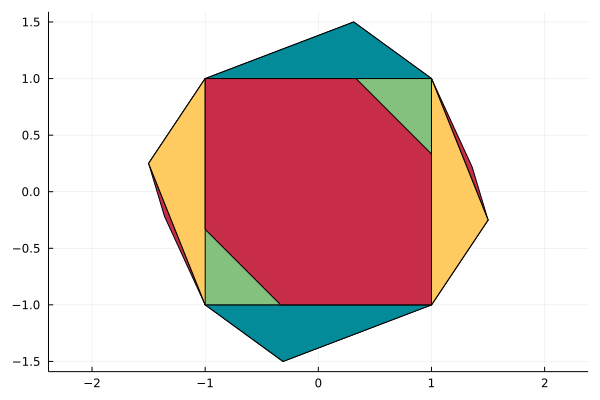

In [10]:
plot(ratio=:equal, tickfont=Plots.font(12))
plot!(min_polytope_3, color=frambo)
plot!(min_polytope_2, color=canard)
plot!(min_polytope_1, color=aurore)
plot!(□, color=lichen)
plot!(max_polytope_1, color=frambo)

### Linear programming approach

As introduced in [R21], we can search over all polyhedra with a given face fan.
The partition can be defined by the face fan of a given polytope as described in [Eq. (4.6), R21].
For `maximal_invariant`, because the sets are represented with the support function,
the fan will be used for the face fan of the polar set
the face fan of the primal set will depend on the value of
the support function on each piece.
For `minimal_invariant`, the sets are represented with the gauge function,
the fac will therefore be used for the face fan of the primal set.

[R21] Raković, S. V.
*Control Minkowski–Lyapunov functions*
Automatica, Elsevier BV, 2021, 128, 109598

We use the face fan of the polytope `pieces8` (which has the same face fan as the octogon `convexhull(□, √2 * ◇)`).

solve_time(model) = 0.00074005126953125
termination_status(model) = MathOptInterface.OPTIMAL
objective_value(model) = 2.6045789025021944
solve_time(model) = 0.0012409687042236328
termination_status(model) = MathOptInterface.OPTIMAL
objective_value(model) = 1.5004084221566498
JuMP.objective_sense(model) = MathOptInterface.MAX_SENSE


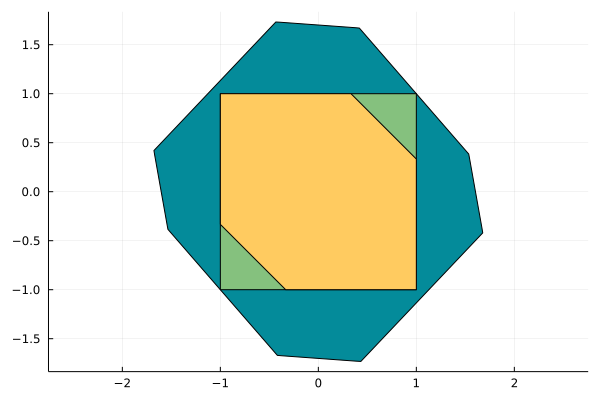

In [11]:
pieces8 = convexhull(□, 1.25 * ◇)
max_polytope = maximal_invariant(Polytope(symmetric=true, piecewise=pieces8), L1_heuristic)
min_polytope = minimal_invariant(Polytope(symmetric=true, piecewise=polar(pieces8)), L1_heuristic)
primal_plot(min_polytope, max_polytope)

The polar plot is as follows:

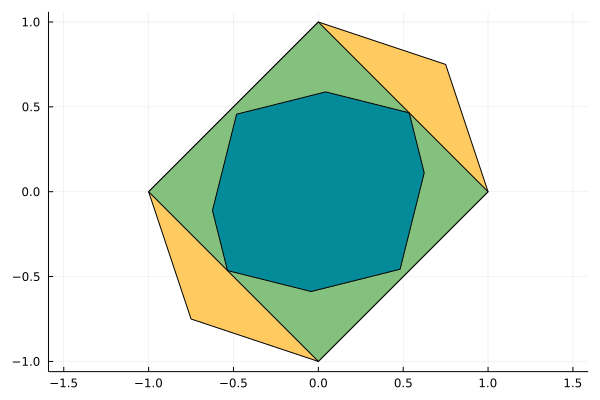

In [12]:
polar_plot(min_polytope, max_polytope)

## Ellipsoidal template

We now consider the ellipsoidal template.
The ellipsoids of maximal volume are given as follows:

solve_time(model) = 0.011825084686279297
termination_status(model) = MathOptInterface.OPTIMAL
objective_value(model) = 0.8953595823720262
solve_time(model) = 0.011631011962890625
termination_status(model) = MathOptInterface.OPTIMAL
objective_value(model) = 0.40521364305805074
JuMP.objective_sense(model) = MathOptInterface.MAX_SENSE


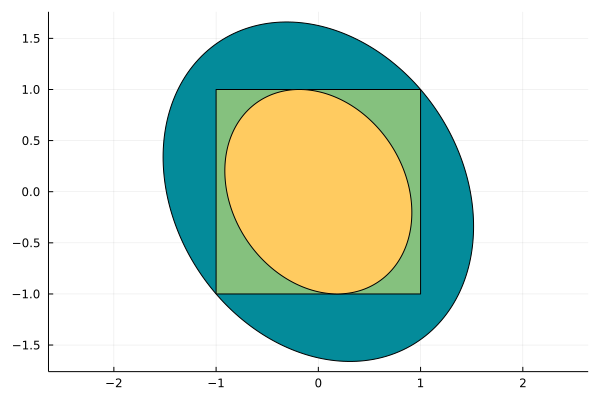

In [13]:
max_ell_vol = maximal_invariant(Ellipsoid(symmetric=true), nth_root)
min_ell_vol = minimal_invariant(Ellipsoid(symmetric=true), nth_root)
primal_plot(min_ell_vol, max_ell_vol)

All ellipsoids are convex so we can also obtain the polar plot:

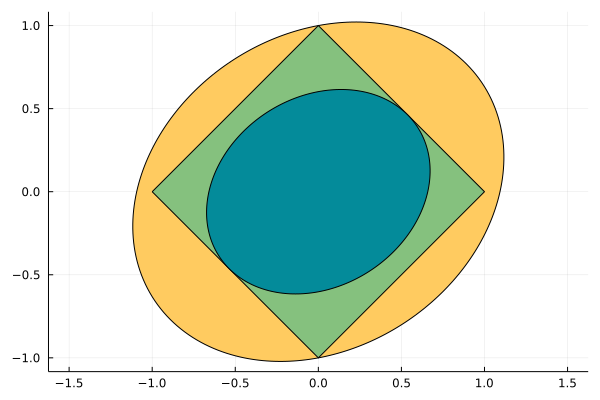

In [14]:
polar_plot(min_ell_vol, max_ell_vol)

The ellipsoids of maximal sum of squared length of its axis.

solve_time(model) = 0.006437063217163086
termination_status(model) = MathOptInterface.OPTIMAL
objective_value(model) = 0.6121580874508952
solve_time(model) = 0.006731986999511719
termination_status(model) = MathOptInterface.OPTIMAL
objective_value(model) = 0.5540898055578214
JuMP.objective_sense(model) = MathOptInterface.MAX_SENSE


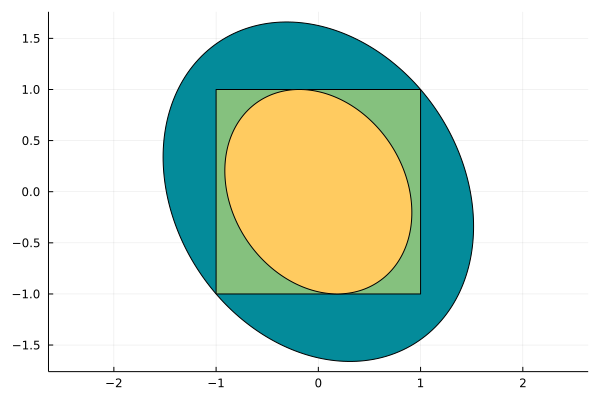

In [15]:
max_ell_L1 = maximal_invariant(Ellipsoid(symmetric=true), vol -> L1_heuristic(vol, ones(2)))
min_ell_L1 = minimal_invariant(Ellipsoid(symmetric=true), vol -> L1_heuristic(vol, ones(2)))
primal_plot(min_ell_L1, max_ell_L1)

And the polar plot is:

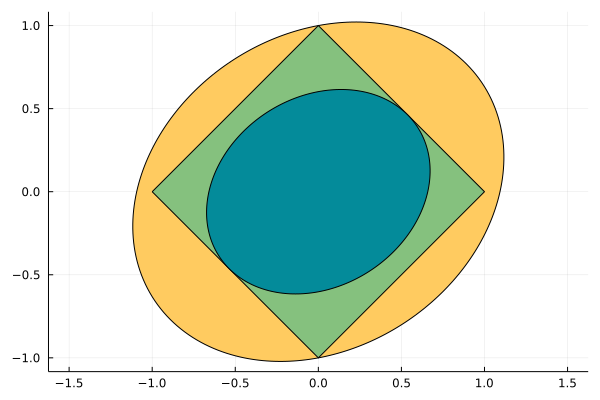

In [16]:
polar_plot(min_ell_vol, max_ell_vol)

## Polyset template

We generalize the previous template to homogeneous polynomials of degree $2d$.
As objective, we use the integral of the polynomial used to represent
the set (either in the support function for `maximal_invariant`
or in the gauge function for `minimal_invariant`) over the square `□`.
We start with quartic polynomials.

solve_time(model) = 0.008951902389526367
termination_status(model) = MathOptInterface.OPTIMAL
objective_value(model) = 0.28212974505596156
solve_time(model) = 0.005671977996826172
termination_status(model) = MathOptInterface.OPTIMAL
objective_value(model) = 0.5734388659811451
JuMP.objective_sense(model) = MathOptInterface.MAX_SENSE


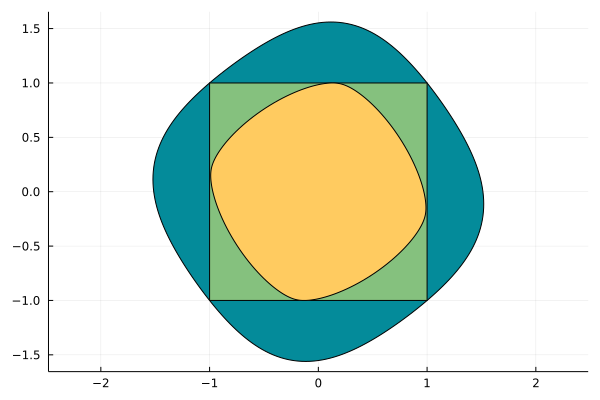

In [17]:
max_4 = maximal_invariant(PolySet(symmetric=true, convex=true, degree=4), vol -> L1_heuristic(vol, ones(2)))
min_4 = minimal_invariant(PolySet(symmetric=true, degree=4), vol -> L1_heuristic(vol, ones(2)))
primal_plot(min_4, max_4)

We now obtain the results for sextic polynomials, note that we do not
impose the sets to be convex for `minimal_invariant`. This is why we don't
show the polar plot for polysets.

solve_time(model) = 0.2780020236968994
termination_status(model) = MathOptInterface.OPTIMAL
objective_value(model) = 0.2010510372844505
solve_time(model) = 0.0059359073638916016
termination_status(model) = MathOptInterface.OPTIMAL
objective_value(model) = 0.3318843656946679
JuMP.objective_sense(model) = MathOptInterface.MAX_SENSE


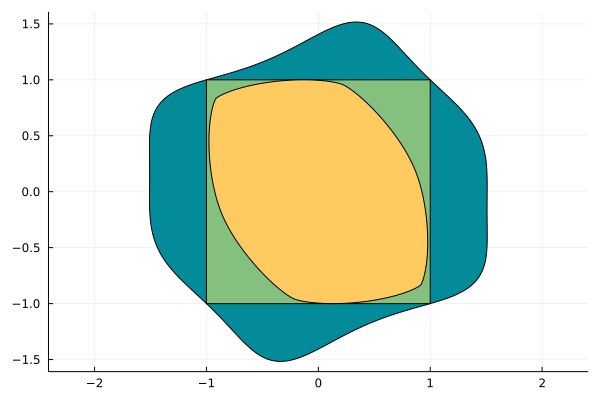

In [18]:
max_6 = maximal_invariant(PolySet(symmetric=true, convex=true, degree=6), vol -> L1_heuristic(vol, ones(2)))
min_6 = minimal_invariant(PolySet(symmetric=true, degree=6), vol -> L1_heuristic(vol, ones(2)))
primal_plot(min_6, max_6)

The nonconvexity is even more apparent for octic polynomials.

solve_time(model) = 0.6304168701171875
termination_status(model) = MathOptInterface.OPTIMAL
objective_value(model) = 0.16138638082788087
solve_time(model) = 0.2961719036102295
termination_status(model) = MathOptInterface.OPTIMAL
objective_value(model) = 0.26800823057757206
JuMP.objective_sense(model) = MathOptInterface.MAX_SENSE


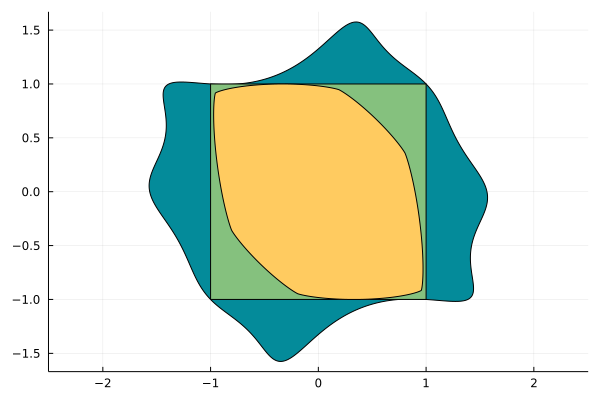

In [19]:
max_8 = maximal_invariant(PolySet(symmetric=true, convex=true, degree=8), vol -> L1_heuristic(vol, □))
min_8 = minimal_invariant(PolySet(symmetric=true, degree=8), vol -> L1_heuristic(vol, □))
primal_plot(min_8, max_8, npoints=1024)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*